/var/folders/vt/8nzlc18n0rjbf94p2wpldl400000gn/T/ipykernel_41551/4167674256.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_data_filtered['Export Value (USD)'] = trade_data_filtered['GDP'] * (trade_data_filtered['Export (% GDP)'] / 100)
/var/folders/vt/8nzlc18n0rjbf94p2wpldl400000gn/T/ipykernel_41551/4167674256.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_data_filtered['Import Value (USD)'] = trade_data_filtered['GDP'] * (trade_data_filtered['Import (% GDP)'] / 100)
/var/folders/vt/

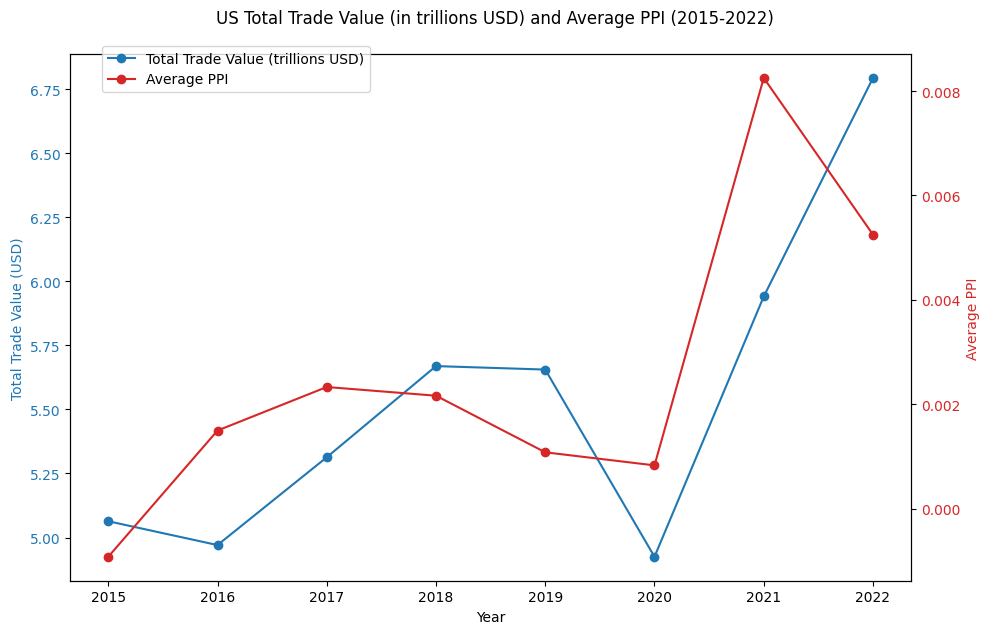

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
trade_data_path = '/Users/ajinkyaphanse/Downloads/worldbank_countries.csv'
inflation_data_path = '/Users/ajinkyaphanse/Downloads/Ap Inflation data.xlsx'
trade_data = pd.read_csv(trade_data_path)
ppi_sector_data = pd.read_excel(inflation_data_path, sheet_name='PPI Sector', skiprows=1)

# Rename and preprocess trade data
trade_data = trade_data[trade_data['Country Code'] == 'USA']
trade_data['Total Trade (% GDP)'] = trade_data['Export (% GDP)'].fillna(0) + trade_data['Import (% GDP)'].fillna(0)
trade_data_filtered = trade_data[(trade_data['Year'] >= 2015) & (trade_data['Year'] <= 2022)]

# Calculate actual Export and Import values in USD
trade_data_filtered['Export Value (USD)'] = trade_data_filtered['GDP'] * (trade_data_filtered['Export (% GDP)'] / 100)
trade_data_filtered['Import Value (USD)'] = trade_data_filtered['GDP'] * (trade_data_filtered['Import (% GDP)'] / 100)
trade_data_filtered['Total Trade Value (USD)'] = trade_data_filtered['Export Value (USD)'] + trade_data_filtered['Import Value (USD)']

# Preprocess PPI data
ppi_sector_data.columns = [
    'Month', 'Total PPI', 'Total less foods, energy, and trade services',
    'Goods', 'Foods', 'Energy', 'Goods less foods and energy', 'Services',
    'Trade', 'Transportation and warehousing', 'Services less trade, transportation, and warehousing'
]
ppi_sector_data['Month'] = pd.to_datetime(ppi_sector_data['Month'])
ppi_for_trade_period = ppi_sector_data[(ppi_sector_data['Month'].dt.year >= 2015) & 
                                       (ppi_sector_data['Month'].dt.year <= 2022)]
annual_ppi = ppi_for_trade_period.groupby(ppi_for_trade_period['Month'].dt.year)['Total PPI'].mean().reset_index()
annual_ppi.columns = ['Year', 'Average PPI']

# Merge the annual trade value data with annual PPI data
combined_data_full = pd.merge(trade_data_filtered[['Year', 'Total Trade Value (USD)']], annual_ppi, on='Year', how='left')

# Plotting both datasets with different scales, converting trade value to line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Trade Value (USD)', color=color)
ax1.plot(combined_data_full['Year'], combined_data_full['Total Trade Value (USD)'] / 1e12, color=color, label='Total Trade Value (trillions USD)', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Average PPI', color=color)
ax2.plot(combined_data_full['Year'], combined_data_full['Average PPI'], color=color, label='Average PPI', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.suptitle('US Total Trade Value (in trillions USD) and Average PPI (2015-2022)', y=1.05)
fig.legend(loc='upper left', bbox_to_anchor=(0.1,1))
plt.show()


In [ ]:
# This was our initial hypothesis - Due to a significant halt in imports, manufacturing faced substantial disruptions, leading to a widespread increase in prices.


/var/folders/vb/s04ttxpn4w12xzgp5y6jpnlh0000gn/T/ipykernel_592/97143333.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_sheets['job vacancies']['time'] = pd.to_datetime(all_sheets['job vacancies']['time']).dt.to_period('Q')
/var/folders/vb/s04ttxpn4w12xzgp5y6jpnlh0000gn/T/ipykernel_592/97143333.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_sheets['housing']['time'] = pd.to_datetime(all_sheets['housing']['time'])


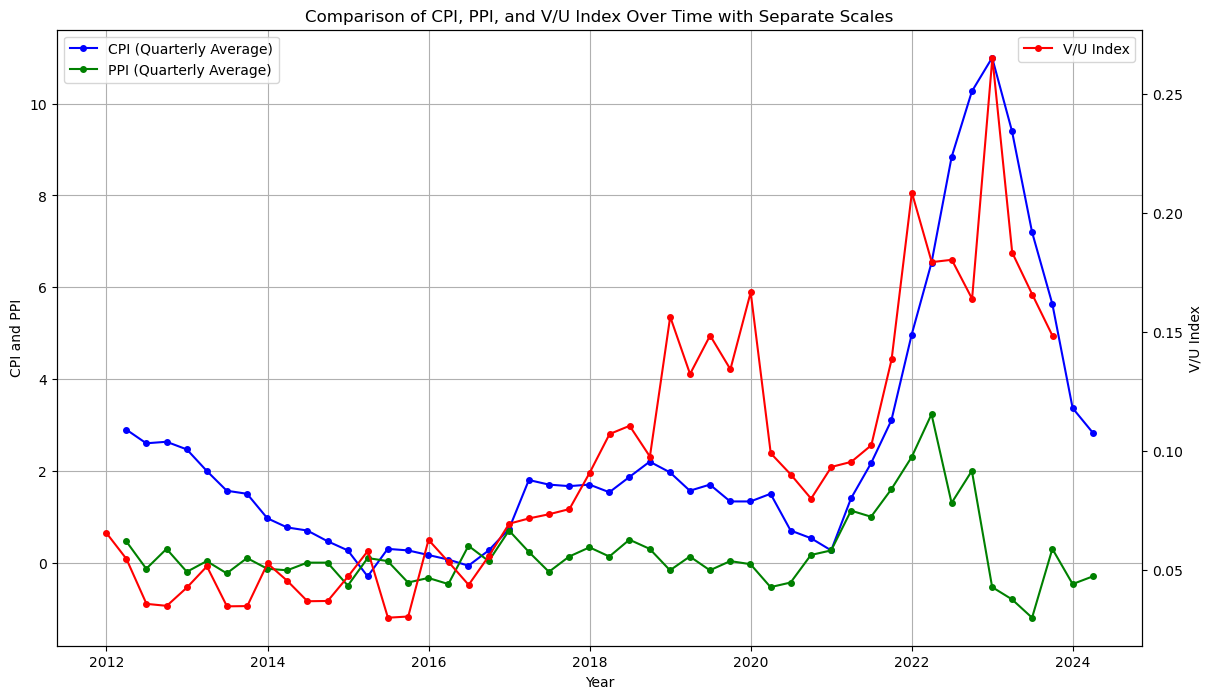

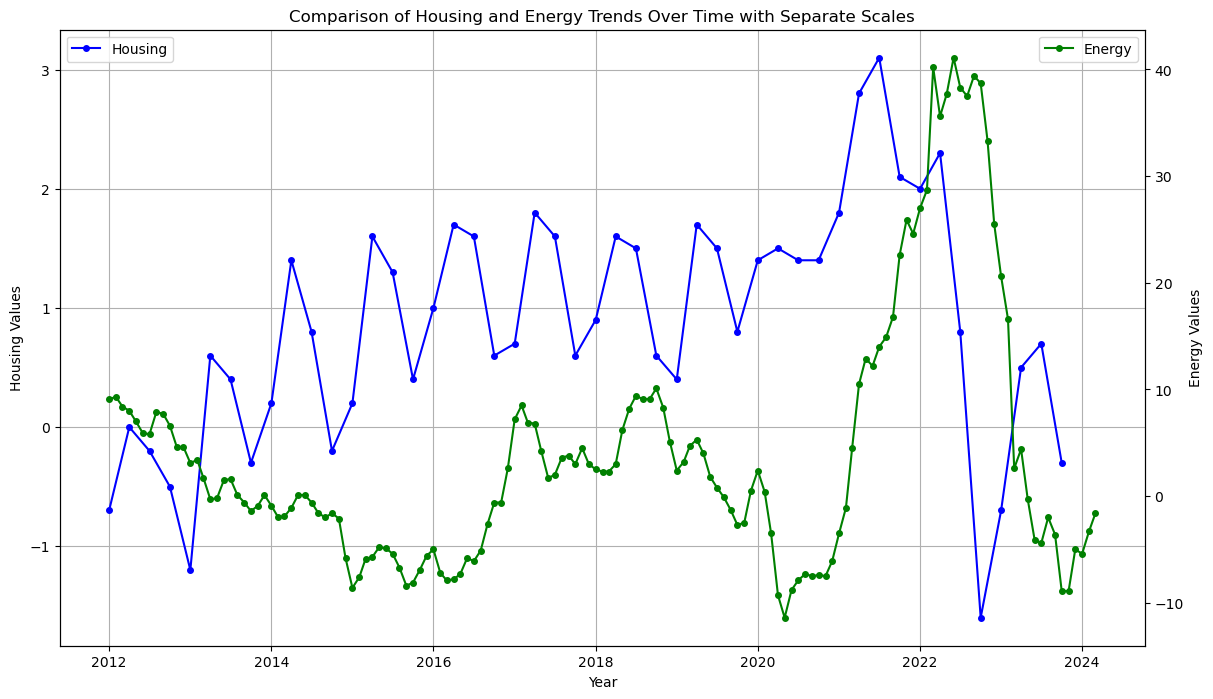

In [1]:
## We have analyzed Europe data to see how CPI, PPI and V/U index was varying across time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
all_sheets = pd.read_excel('Euro Stats.xlsx', sheet_name=None)

# Ensure 'time' columns are datetime objects where necessary
all_sheets['job vacancies']['time'] = pd.to_datetime(all_sheets['job vacancies']['time']).dt.to_period('Q')
all_sheets['unemployment']['time'] = pd.to_datetime(all_sheets['unemployment']['time'])

# Resampling the unemployment data to quarterly and merging with job vacancies
unemployment_quarterly = all_sheets['unemployment'].resample('Q', on='time').mean().value
unemployment_quarterly.index = unemployment_quarterly.index.to_period('Q')
merged_data = pd.merge(left=all_sheets['job vacancies'], right=unemployment_quarterly, left_on='time', right_index=True, how='inner')
merged_data['V/U_index'] = merged_data['value_x'] / merged_data['value_y']

# Resampling CPI and PPI data to quarterly
cpi_quarterly = all_sheets['cpi'].resample('Q', on='time').mean()
ppi_quarterly = all_sheets['ppi'].resample('Q', on='time').mean()

# Filtering data from 2012 onward
start_date = pd.Timestamp('2012-01-01')
merged_data = merged_data[merged_data['time'].dt.start_time >= start_date]
cpi_quarterly = cpi_quarterly[cpi_quarterly.index >= start_date]
ppi_quarterly = ppi_quarterly[ppi_quarterly.index >= start_date]
all_sheets['housing']['time'] = pd.to_datetime(all_sheets['housing']['time'])
all_sheets['energy']['time'] = pd.to_datetime(all_sheets['energy']['time'])
filtered_housing = all_sheets['housing'][all_sheets['housing']['time'] >= start_date]
filtered_energy = all_sheets['energy'][all_sheets['energy']['time'] >= start_date]



# Plotting all data without unnecessary index conversion
# First plot: CPI, PPI, and V/U Index
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(cpi_quarterly.index, cpi_quarterly['cpi'], label='CPI (Quarterly Average)', color='b', marker='o', linestyle='-', markersize=4)
ax1.plot(ppi_quarterly.index, ppi_quarterly['ppi'], label='PPI (Quarterly Average)', color='g', marker='o', linestyle='-', markersize=4)
ax1.set_xlabel('Year')
ax1.set_ylabel('CPI and PPI')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(merged_data['time'].dt.to_timestamp(), merged_data['V/U_index'], label='V/U Index', color='r', marker='o', linestyle='-', markersize=4)
ax2.set_ylabel('V/U Index')
ax2.legend(loc='upper right')
plt.title('Comparison of CPI, PPI, and V/U Index Over Time with Separate Scales')

# Second plot: Housing and Energy
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(filtered_housing['time'], filtered_housing['value'], label='Housing', color='b', marker='o', linestyle='-', markersize=4)
ax1.set_xlabel('Year')
ax1.set_ylabel('Housing Values')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(filtered_energy['time'], filtered_energy['value'], label='Energy', color='g', marker='o', linestyle='-', markersize=4)
ax2.set_ylabel('Energy Values')
ax2.legend(loc='upper right')
plt.title('Comparison of Housing and Energy Trends Over Time with Separate Scales')

plt.show()


In [ ]:
## An interesting observation from the data is that both CPI and the V/U Index reached their peaks simultaneously

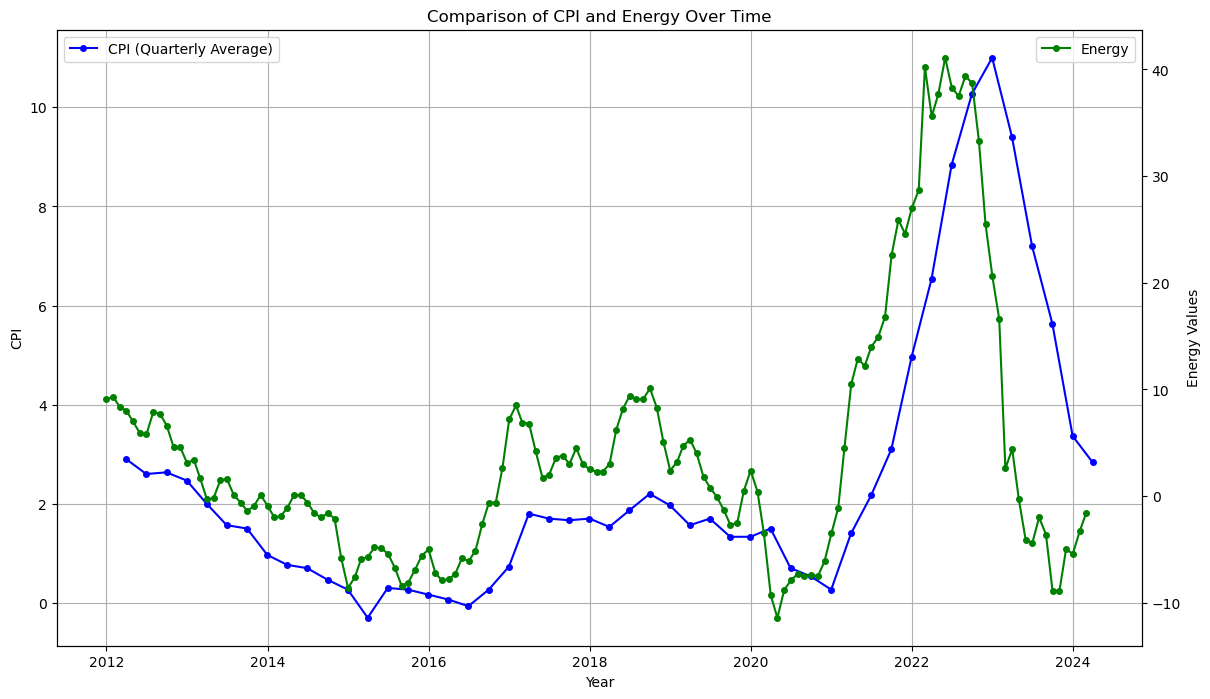

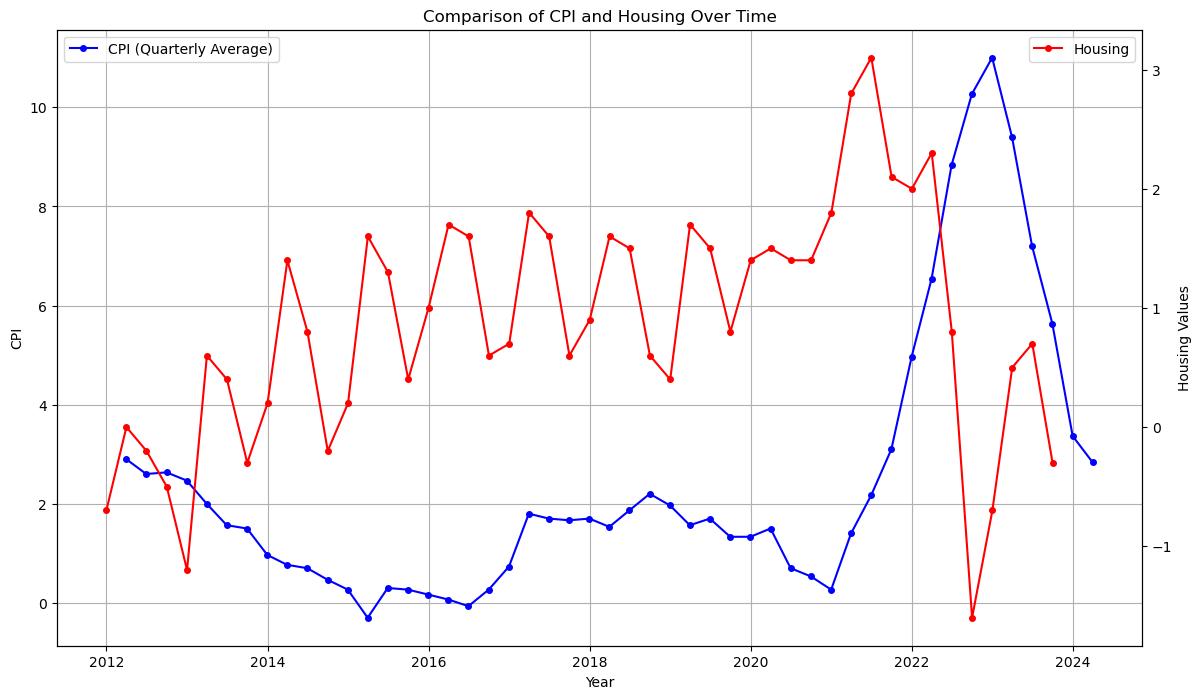

In [2]:
# First plot: CPI and Energy in a separate figure
fig1, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(cpi_quarterly.index, cpi_quarterly['cpi'], label='CPI (Quarterly Average)', color='b', marker='o', linestyle='-', markersize=4)
ax1.set_xlabel('Year')
ax1.set_ylabel('CPI')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1_2 = ax1.twinx()
ax1_2.plot(filtered_energy['time'], filtered_energy['value'], label='Energy', color='g', marker='o', linestyle='-', markersize=4)
ax1_2.set_ylabel('Energy Values')
ax1_2.legend(loc='upper right')
plt.title('Comparison of CPI and Energy Over Time')
plt.show()

# Second plot: CPI and Housing in a separate figure
fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.plot(cpi_quarterly.index, cpi_quarterly['cpi'], label='CPI (Quarterly Average)', color='b', marker='o', linestyle='-', markersize=4)
ax2.set_xlabel('Year')
ax2.set_ylabel('CPI')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2_2 = ax2.twinx()
ax2_2.plot(filtered_housing['time'], filtered_housing['value'], label='Housing', color='r', marker='o', linestyle='-', markersize=4)
ax2_2.set_ylabel('Housing Values')
ax2_2.legend(loc='upper right')
plt.title('Comparison of CPI and Housing Over Time')
plt.show()



/var/folders/vb/s04ttxpn4w12xzgp5y6jpnlh0000gn/T/ipykernel_592/3013162877.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cpi_sector_total['All items'] = pd.to_numeric(filtered_cpi_sector_total['All items'], errors='coerce')


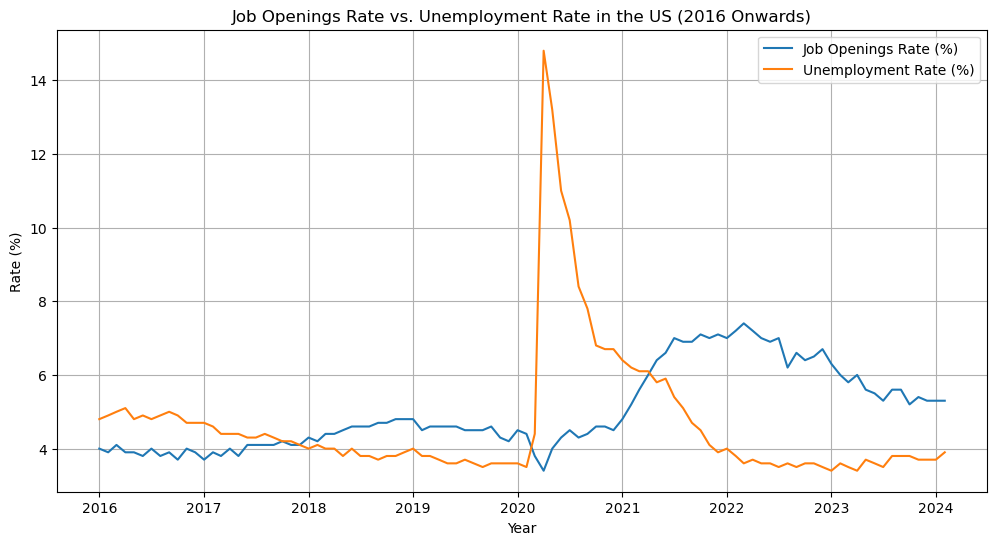

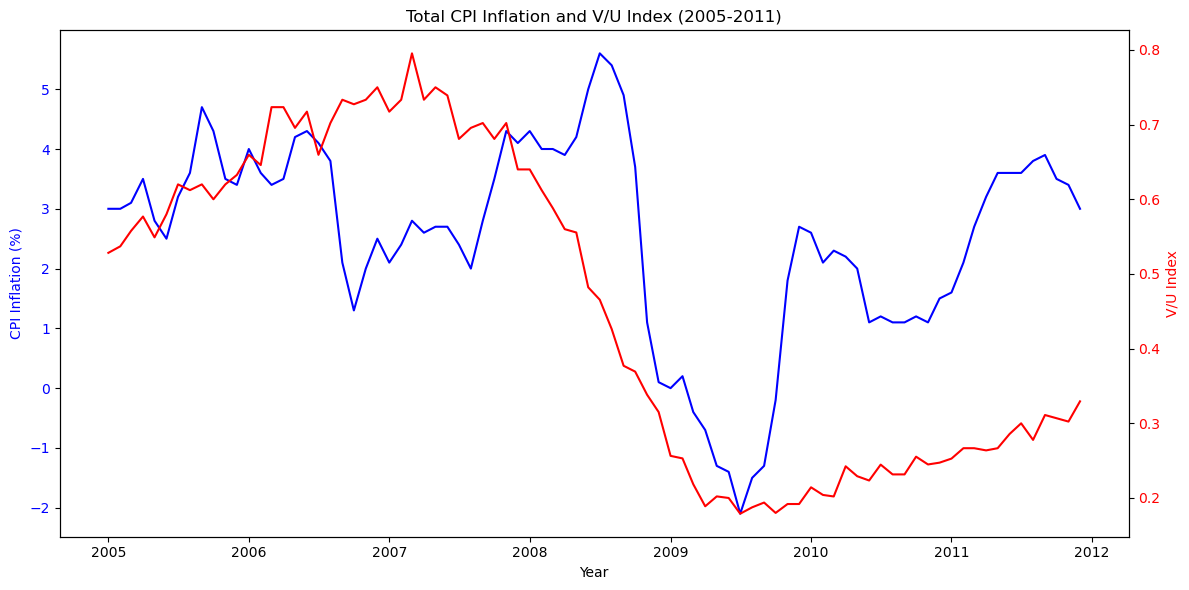

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the Excel file
file_path = 'Ap US Inflation data.xlsx'
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Data preparation for Job Openings vs. Unemployment Rate
job_openings_vs_unemployment = all_sheets["job openings rate vs. unemploym"]
job_openings_vs_unemployment['Month'] = pd.to_datetime(job_openings_vs_unemployment['Month'])
filtered_data_2016 = job_openings_vs_unemployment[job_openings_vs_unemployment['Month'] >= '2016-01-01']

# Data preparation for CPI and V/U Index
cpi_sector = all_sheets['CPI Sector']
cpi_sector.columns = cpi_sector.iloc[0]  # Set header row as column names
cpi_sector = cpi_sector.drop(0)
cpi_sector['Month'] = pd.to_datetime(cpi_sector['Month'])
filtered_cpi_sector_total = cpi_sector[(cpi_sector['Month'] >= '2005-01-01') & (cpi_sector['Month'] <= '2011-12-31')]
filtered_cpi_sector_total['All items'] = pd.to_numeric(filtered_cpi_sector_total['All items'], errors='coerce')

filtered_vu_index_2005_2011 = job_openings_vs_unemployment[
    (job_openings_vs_unemployment['Month'] >= '2005-01-01') & 
    (job_openings_vs_unemployment['Month'] <= '2011-12-31')
]

# Plotting Job Openings vs. Unemployment Rate (2016 onwards)
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_2016['Month'], filtered_data_2016['Job openings rate']*100, label='Job Openings Rate (%)')
plt.plot(filtered_data_2016['Month'], filtered_data_2016['Unemployment rate']*100, label='Unemployment Rate (%)')
plt.title('Job Openings Rate vs. Unemployment Rate in the US (2016 Onwards)')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Total CPI Inflation and V/U Index (2005-2011)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(filtered_cpi_sector_total['Month'], filtered_cpi_sector_total['All items']*100, 'b-', label='Total CPI Inflation (%)')
ax1.set_xlabel('Year')
ax1.set_ylabel('CPI Inflation (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(filtered_vu_index_2005_2011['Month'], filtered_vu_index_2005_2011['V/U Index'], 'r-', label='V/U Index')
ax2.set_ylabel('V/U Index', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Total CPI Inflation and V/U Index (2005-2011)')
fig.tight_layout()
plt.show()



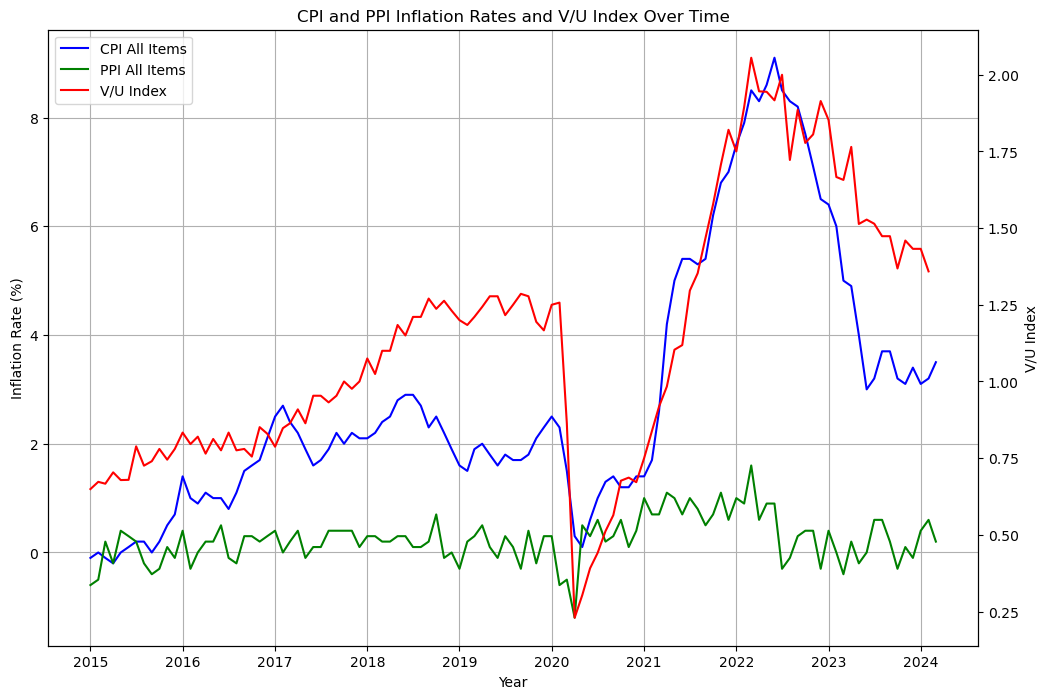

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
data = pd.ExcelFile('Ap US Inflation data.xlsx')

# Load the relevant sheets
cpi_data = pd.read_excel(data, sheet_name='CPI Sector', skiprows=1)
ppi_data = pd.read_excel(data, sheet_name='PPI Sector', skiprows=1)
vu_data = pd.read_excel(data, sheet_name='job openings rate vs. unemploym')

# Renaming columns for clarity
cpi_data.columns = ['Date', 'CPI All Items', 'Food', 'Food at Home', 'Food Away from Home', 'Energy',
                    'Gasoline', 'Electricity', 'Natural Gas', 'Excluding Food and Energy'] + list(cpi_data.columns[10:])
ppi_data.columns = ['Date', 'PPI All Items', 'Excluding Foods and Energy', 'Goods', 'Foods',
                    'Energy', 'Goods Excluding Food and Energy', 'Services', 'Trade',
                    'Transportation and Warehousing', 'Services Excluding Trade, Transportation, and Warehousing']
vu_data.columns = ['Month', 'Job openings rate', 'Unemployment rate', 'V/U Index']

# Convert date columns to datetime
cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])
ppi_data['Date'] = pd.to_datetime(ppi_data['Date'])
vu_data['Month'] = pd.to_datetime(vu_data['Month'])

# Filter data from 2015 onwards
cpi_filtered = cpi_data[cpi_data['Date'] >= '2015-01-01']
ppi_filtered = ppi_data[ppi_data['Date'] >= '2015-01-01']
vu_filtered = vu_data[vu_data['Month'] >= '2015-01-01']

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# CPI and PPI on the primary y-axis
ax1.plot(cpi_filtered['Date'], cpi_filtered['CPI All Items'] * 100, label='CPI All Items', color='blue')
ax1.plot(ppi_filtered['Date'], ppi_filtered['PPI All Items'] * 100, label='PPI All Items', color='green')
ax1.set_xlabel('Year')
ax1.set_ylabel('Inflation Rate (%)')
ax1.set_title('CPI and PPI Inflation Rates and V/U Index Over Time')
ax1.grid(True)

# V/U index on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(vu_filtered['Month'], vu_filtered['V/U Index'], label='V/U Index', color='red')
ax2.set_ylabel('V/U Index')

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


In [1]:
## China CPI, PPI plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
excel_file_path = r'/Users/ajinkyaphanse/Downloads/China (2).xlsx'
xls = pd.ExcelFile(excel_file_path)
sheet_names = xls.sheet_names
sheet_names

['CPI Inflation', 'CPI Food', 'PPI Inflation', 'Youth Unemployment']

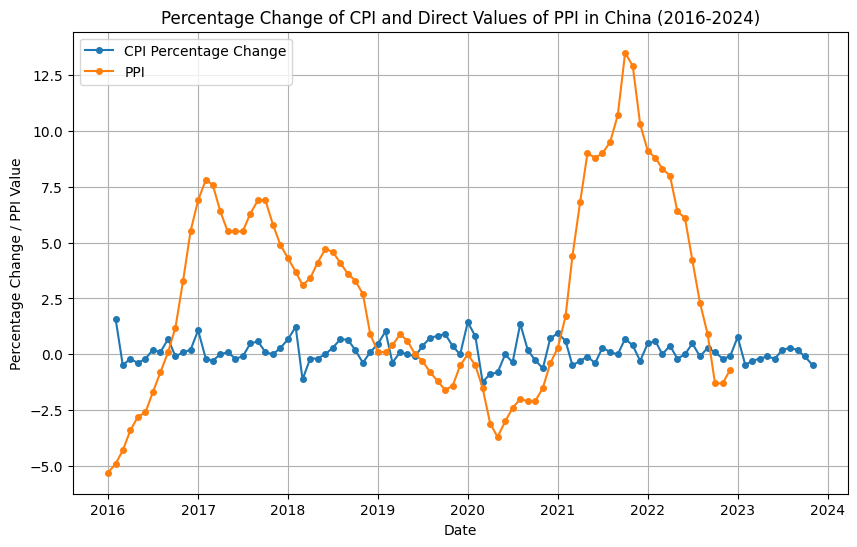

In [2]:
cpi_data = pd.read_excel(excel_file_path, sheet_name="CPI Inflation")
ppi_data = pd.read_excel(excel_file_path, sheet_name="PPI Inflation")

## Filtering the data for the years 2016 to 2024
cpi_data = cpi_data[cpi_data['DATE'].dt.year.between(2016, 2024)]
ppi_data = ppi_data[ppi_data['DATE'].dt.year.between(2016, 2024)]

## Calculating percentage change for CPI
cpi_data['CPI_pct_change'] = cpi_data['CPI'].pct_change() * 100

plt.figure(figsize=(10, 6))
plt.plot(cpi_data['DATE'], cpi_data['CPI_pct_change'], label='CPI Percentage Change', marker='o',markersize=4)
plt.plot(ppi_data['DATE'], ppi_data['CHNPIEATI01GYM'], label='PPI', marker='o',markersize=4)
plt.title('Percentage Change of CPI and Direct Values of PPI in China (2016-2024)')
plt.xlabel('Date')
plt.ylabel('Percentage Change / PPI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## From this graph we can clearly observe that China managed to control their CPI percentage change although we can see some noticeable peaks in PPI index values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/us_v_by_u.csv')
data['Time'] = pd.to_datetime(data['Month'])
data['V/U Index in %'] = data['V/U Index'].str.rstrip('%').astype('int') / 100

In [3]:
data.tail()

,Month,Job openings rate,Unemployment rate,V/U Index,Time,V/U Index in %
274,Oct 2023,5.20%,3.80%,137%,2023-10-01,1.37
275,Nov 2023,5.40%,3.70%,146%,2023-11-01,1.46
276,Dec 2023,5.30%,3.70%,143%,2023-12-01,1.43
277,Jan 2024,5.30%,3.70%,143%,2024-01-01,1.43
278,Feb 2024,5.30%,3.90%,136%,2024-02-01,1.36


In [4]:
df = data[['Time','V/U Index in %']]
df['log_returns'] = np.log(1 + df['V/U Index in %'].pct_change())
mu = df['log_returns'].mean()
sigma = df['log_returns'].std()

/var/folders/5m/0jfggm0n5q39rqpgq1kr1wk00000gn/T/ipykernel_59127/172799664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_returns'] = np.log(1 + df['V/U Index in %'].pct_change())


In [5]:
df.head()

,Time,V/U Index in %,log_returns
0,2000-12-01,0.95,NaN
1,2001-01-01,0.90,-0.054067
2,2001-02-01,0.88,-0.022473
3,2001-03-01,0.81,-0.082888
4,2001-04-01,0.77,-0.050644


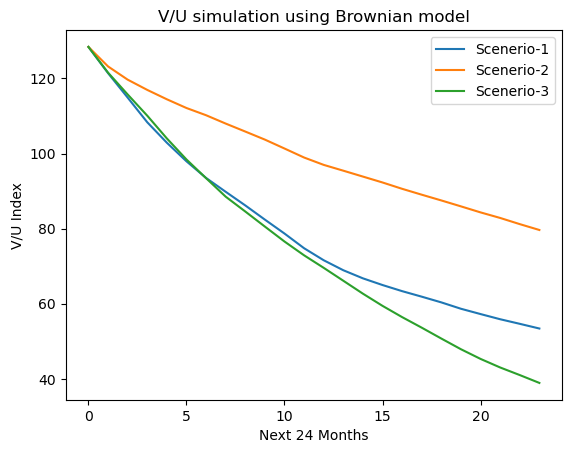

In [6]:
# Simulate the GBM model and visualize the results
S0 = df[['log_returns']].iloc[-1]  # Current price of the stock
n_simulations = 3  # Number of simulations
simulation_days = 24  # Simulation days (1 year)

plot_labels = ['Scenerio-1','Scenerio-2','Scenerio-3']
# Simulate the GBM model
for i in range(n_simulations):
    simulated_prices = []
    simulated_prices.append(S0)
    for month in range(1, simulation_days):
        drift = mu - (0.5 * sigma**2)
        shock = sigma * np.random.normal()
        price = simulated_prices[-1] * np.exp(drift + shock)
        simulated_prices.append(price)
    initial_price = 135
    np_sim_prices = np.array(simulated_prices)
    original_vals = np.exp(np_sim_prices.cumsum()) * initial_price
    plt.plot(original_vals, label=plot_labels[i])
    plt.legend()

plt.xlabel('Next 24 Months')
plt.ylabel('V/U Index')
plt.title('V/U simulation using Brownian model')
plt.show()

In [7]:
## INflation rate forecast

In [8]:
data = pd.read_csv('data/US CPI Sector.csv')
data.columns = data.iloc[0]
data = data[1:]
data['Time'] = pd.to_datetime(data['Month'])
data['All items in %'] = data['All items'].str.rstrip('%').astype('float')

In [9]:
data.tail(2)

,Month,All items,Food,Food at home,Food away from home,Energy,Gasoline (all types),Electricity,Natural gas (piped),All items less food and energy,Commodities less food and energy commodities,Apparel,New vehicles,Medical care commodities,Services less energy services,Shelter,Medical care services,Education and communication,Time,All items in %
240,Feb 2024,3.20%,2.20%,1.00%,4.50%,-1.90%,-3.90%,3.60%,-8.80%,3.80%,-0.30%,0.00%,0.40%,2.90%,5.20%,5.70%,1.10%,0.40%,2024-02-01,3.2
241,Mar 2024,3.50%,2.20%,1.20%,4.20%,2.10%,1.30%,5.00%,-3.20%,3.80%,-0.70%,0.40%,-0.10%,2.50%,5.40%,5.70%,2.10%,0.20%,2024-03-01,3.5


In [10]:
df = data[['Time','All items in %']]
df['log_returns'] = np.log(1 + df['All items in %'].pct_change())
df.replace([np.inf, -np.inf], 0, inplace=True) 
df.fillna(0,inplace=True)
df['log_returns'] = df['log_returns'].astype('float')
df['log_returns'] = pd.to_numeric(df['log_returns'], errors='coerce')
mu = df['log_returns'].mean()
sigma = df['log_returns'].std()

/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/5m/0jfggm0n5q39rqpgq1kr1wk00000gn/T/ipykernel_59127/1249505195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_returns'] = np.log(1 + df['All items in %'].pct_change())
/var/folders/5m/0jfggm0n5q39rqpgq1kr1wk00000gn/T/ipykernel_59127/1249505195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

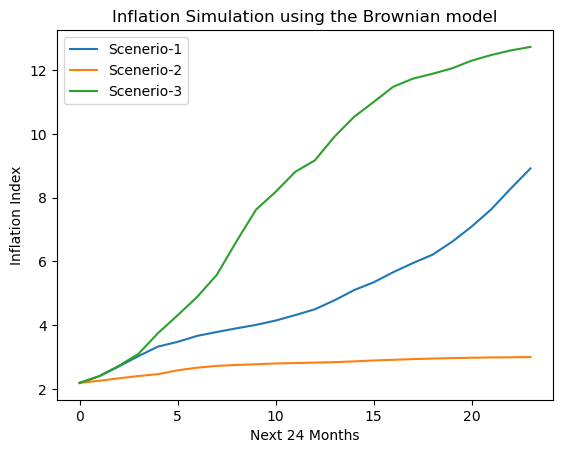

In [11]:
# Simulate the GBM model and visualize the results
S0 = df[['log_returns']].iloc[-1]  # Current price of the stock
n_simulations = 3  # Number of simulations
simulation_days = 24  # Simulation days (1 year)

plot_labels = ['Scenerio-1','Scenerio-2','Scenerio-3']
# Simulate the GBM model
for i in range(n_simulations):
    simulated_prices = []
    simulated_prices.append(S0)
    for month in range(1, simulation_days):
        drift = mu - (0.5 * sigma**2)
        shock = sigma * np.random.normal()
        price = simulated_prices[-1] * np.exp(drift + shock)
        simulated_prices.append(price)
    initial_price = 2
    np_sim_prices = np.array(simulated_prices)
    original_vals = np.exp(np_sim_prices.cumsum()) * initial_price
    plt.plot(original_vals, label=plot_labels[i])
    plt.legend()

plt.xlabel('Next 24 Months')
plt.ylabel('Inflation Index')
plt.title('Inflation Simulation using the Brownian model')
plt.show()

In [1]:
## Plot of tesla revenue vs operational expense

In [2]:
excel_file_path = r'C:\Users\sajee\Downloads\China (2).xlsx'
xls = pd.ExcelFile(excel_file_path)
sheet_names = xls.sheet_names
sheet_names

['CPI Inflation', 'CPI Food', 'PPI Inflation', 'Youth Unemployment']

In [3]:
youth_unemployment_data = pd.read_excel(excel_file_path, sheet_name='Youth Unemployment')
youth_unemployment_data.head()

,Date,Revenue,Operating Expense
0,2023-12-31,25167.0,23103.0
1,2023-09-30,23350.0,21586.0
2,2023-06-30,24927.0,22528.0
3,2023-03-31,23329.0,20665.0
4,2022-12-31,24318.0,20417.0


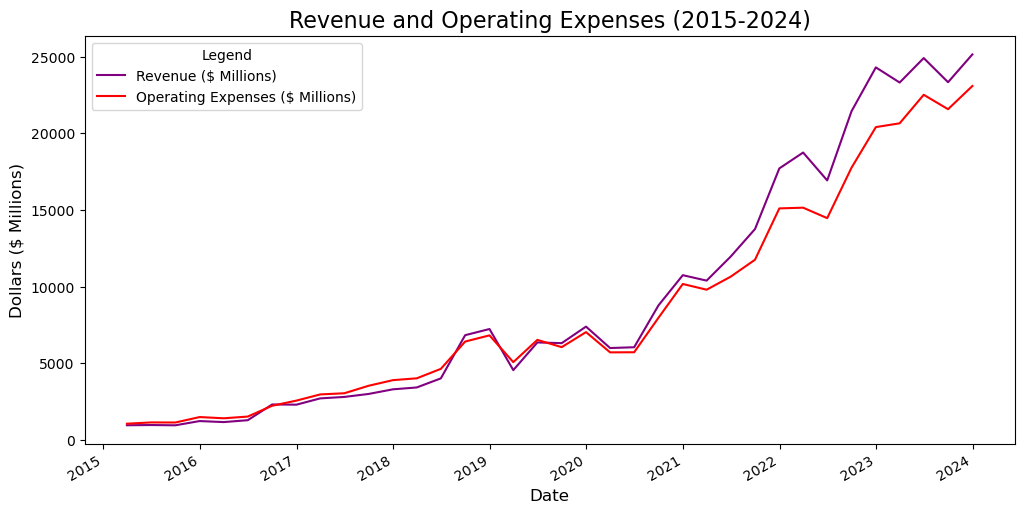

In [4]:
import matplotlib.dates as mdates
filtered_data = youth_unemployment_data[(youth_unemployment_data['Date'] >= "2015-01-01") & 
                                        (youth_unemployment_data['Date'] <= "2024-12-31")]

# Re-plotting the filtered data
plt.figure(figsize=(12, 6))

sns.lineplot(x='Date', y='Revenue', data=filtered_data, label='Revenue ($ Millions)', color='purple')
sns.lineplot(x='Date', y='Operating Expense', data=filtered_data, label='Operating Expenses ($ Millions)', color='red')

plt.title("Revenue and Operating Expenses (2015-2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Dollars ($ Millions)", fontsize=12)
plt.legend(title='Legend')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Automatic date rotation for better readability

plt.show()

In [5]:
## For the above graph we have tried plotting the revenue and operational expense in millions for years 2015-2024. This graph is not giving better insights so we tried to find the percentage change

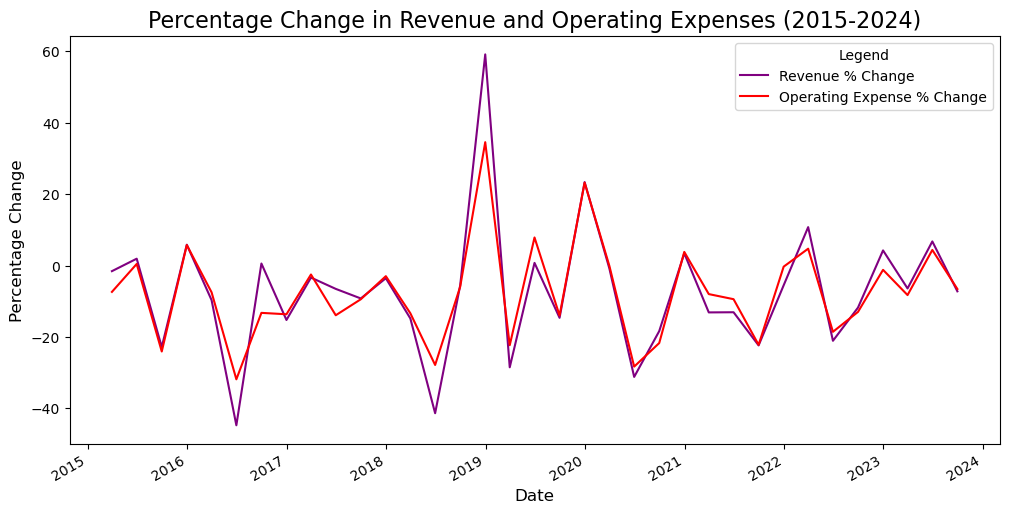

In [6]:
filtered_data['Revenue % Change'] = filtered_data['Revenue'].pct_change() * 100
filtered_data['Operating Expense % Change'] = filtered_data['Operating Expense'].pct_change() * 100

# Plotting percentage changes
plt.figure(figsize=(12, 6))

sns.lineplot(x='Date', y='Revenue % Change', data=filtered_data, label='Revenue % Change', color='purple')
sns.lineplot(x='Date', y='Operating Expense % Change', data=filtered_data, label='Operating Expense % Change', color='red')

plt.title("Percentage Change in Revenue and Operating Expenses (2015-2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage Change", fontsize=12)
plt.legend(title='Legend')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Automatic date rotation for better readability

plt.show()

In [7]:
## The above graph clearly shows noticeable 3 spikes in prcentage change during covid-19.

In [8]:
## Now for PPI graph we gathered dataset to show the PPI for motor vehicle manufacturing during covid and see if we can find any trends or patters

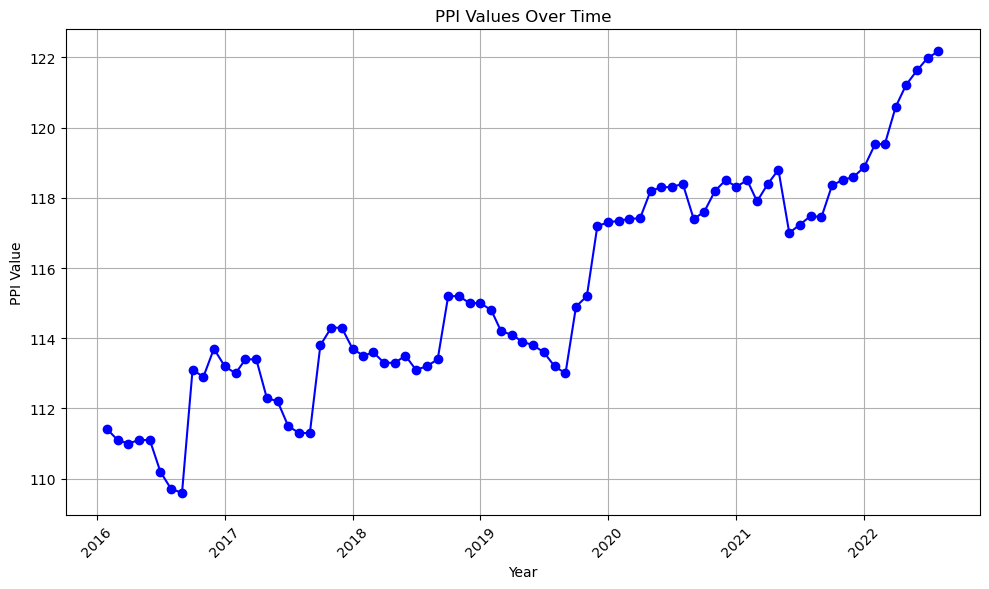

In [9]:
df = pd.read_csv(r"C:\Users\sajee\Downloads\PCU33613361 (1).csv")
df['DATE'] = pd.to_datetime(df['DATE'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['PCU33613361'], marker='o', color='b', linestyle='-')

plt.title('PPI Values Over Time')
plt.xlabel('Year')
plt.ylabel('PPI Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
## We can clearly observe that there is a high increase in PPI values starting from early 2020

In [11]:
df.head(10) # This is how our PPI data looks like

,DATE,PCU33613361
0,2016-02-01,111.4
1,2016-03-01,111.1
2,2016-04-01,111.0
3,2016-05-01,111.1
4,2016-06-01,111.1
5,2016-07-01,110.2
6,2016-08-01,109.7
7,2016-09-01,109.6
8,2016-10-01,113.1
9,2016-11-01,112.9


In [12]:
## Now we gathered data for unemployment in automotive sector during the following years.

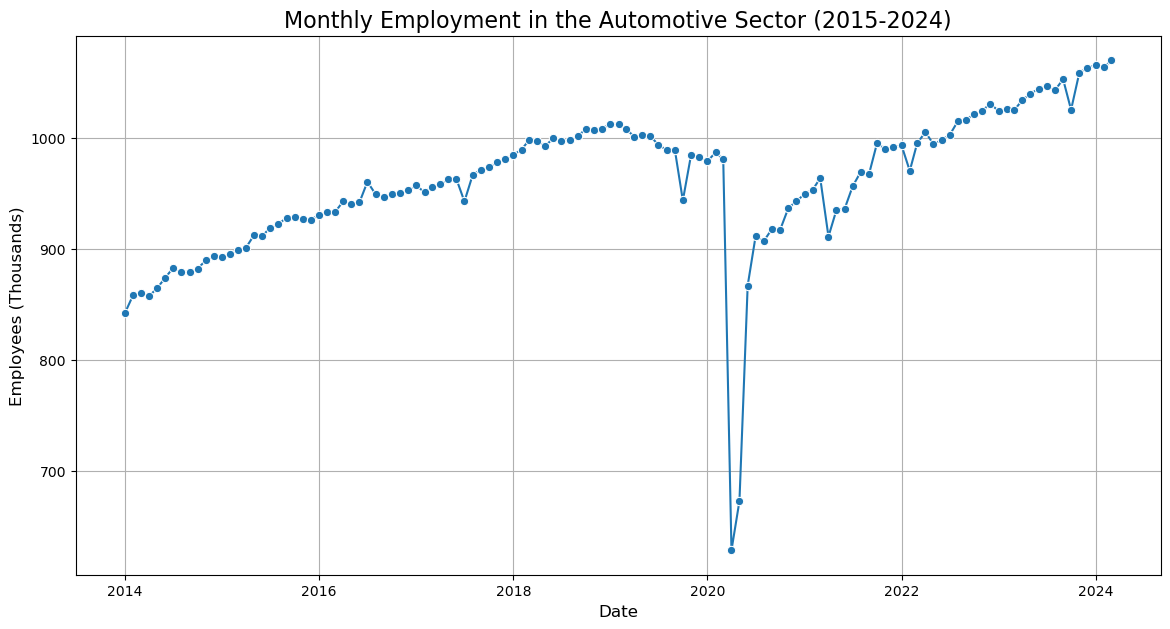

In [13]:
import datetime
automotive_employment_filtered = pd.read_excel(r"C:\Users\sajee\Downloads\Employment_automotive.xlsx")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def get_first_day_of_month(year, month):
    return datetime.datetime(year=int(year), month=int(month), day=1)

dates = []
values = []
for index, row in automotive_employment_filtered.iterrows():
    year = row['Year']
    for month in months:
        if pd.notna(row[month]):
            date = get_first_day_of_month(year, months.index(month)+1)
            dates.append(date)
            values.append(row[month])

employment_time_series = pd.DataFrame({
    'Date': dates,
    'Employees (Thousands)': values
})

plt.figure(figsize=(14, 7))
sns.lineplot(data=employment_time_series, x='Date', y='Employees (Thousands)', marker='o')
plt.title('Monthly Employment in the Automotive Sector (2015-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Employees (Thousands)', fontsize=12)
plt.grid(True)
plt.show()

In [14]:
## Clearly a huge dip in employee count in automotive sector between 2020 and 2022

In [15]:
automotive_employment_filtered.head(10) ## Overview of dataset

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2014,842.5,858.8,860.6,857.4,864.5,873.9,883.0,878.8,879.5,882.1,889.8,893.2
1,2015,892.3,895.6,899.4,901.1,912.3,911.4,919.2,922.3,928.1,928.8,926.8,925.9
2,2016,930.9,933.2,933.1,942.9,940.3,941.9,960.4,949.1,947.1,949.0,950.2,952.8
3,2017,957.1,950.9,956.0,958.0,962.7,962.8,942.7,966.5,971.4,973.5,977.9,981.1
4,2018,984.6,989.4,997.9,997.0,992.9,999.5,997.0,997.7,1001.6,1007.9,1007.5,1008.3
5,2019,1012.5,1012.1,1008.0,1001.1,1002.4,1001.3,993.8,989.0,989.0,943.6,984.7,983.1
6,2020,978.8,986.8,980.6,628.6,672.9,867.0,911.7,907.1,918.2,917.1,936.7,942.9
7,2021,949.3,953.4,963.7,911.1,935.0,936.2,956.3,969.6,967.7,995.4,989.5,991.3
8,2022,993.2,970.3,995.3,1005.1,994.3,998.1,1002.5,1015.0,1016.4,1021.3,1024.5,1030.7
9,2023,1024.2,1026.1,1025.0,1034.0,1039.7,1044.1,1047.0,1042.7,1052.8,1025.3,1058.5,1063.1
